<a href="https://colab.research.google.com/github/gl0bsec/GSI_reddit/blob/main/datamapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [ ]:
!pip -q install semchunk
!pip -q install pacmap
!pip -q install hdbscan
# !pip -q install cosmograph
!pip -q install pyMuPDF
# !pip -q install datamapplot
!pip install -q bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00


### Advanced preprocessing

In [ ]:
import pandas as pd
import re
from collections import defaultdict
from tqdm import tqdm

# --- PARAMETERS ---
JACCARD_THRESHOLD = 0.50
TEXT_COLUMN = 'object_id'       # Column containing the post text
INPUT_FILE = 'fb_preprocessed.csv'
OUTPUT_FILE = 'filtered_posts_exact_jaccard.csv'

# --- LOAD DATA ---
df = pd.read_csv(INPUT_FILE)
texts = df[TEXT_COLUMN].fillna("").astype(str)

# --- TOKENIZATION ---
def tokenize(text):
    # Remove URLs (http, https, and www formats)
    text_no_urls = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove extra whitespace and strip leading/trailing spaces
    text_clean = " ".join(text_no_urls.split())
    # Convert text to lowercase
    text_clean = text_clean.lower()
    # Tokenize into words (alphanumeric tokens)
    return set(re.findall(r'\b\w+\b', text_clean))


tokenized_texts = [tokenize(text) for text in texts]

# --- BUILD INVERTED INDEX ---
# Map each token to the set of indices (posts) that contain it.
inverted_index = defaultdict(set)
for idx, tokens in enumerate(tokenized_texts):
    for token in tokens:
        inverted_index[token].add(idx)

# --- EXACT JACCARD SIMILARITY FUNCTION ---
def jaccard_similarity(set1, set2):
    union = set1 | set2
    if not union:
        return 0.0
    inter = set1 & set2
    return len(inter) / len(union)

# --- FIND POSTS WITH AT LEAST ONE MATCH ---
has_similar = [False] * len(tokenized_texts)

print("Computing exact Jaccard similarities...")
for i in tqdm(range(len(tokenized_texts))):
    tokens_i = tokenized_texts[i]
    # Gather candidate indices from the inverted index for all tokens in the post
    candidate_indices = set()
    for token in tokens_i:
        candidate_indices.update(inverted_index[token])
    candidate_indices.discard(i)  # Remove self-comparison

    for j in candidate_indices:
        # If we already found a match, no need to continue for this post
        if has_similar[i]:
            break
        sim = jaccard_similarity(tokens_i, tokenized_texts[j])
        if sim >= JACCARD_THRESHOLD:
            has_similar[i] = True
            break

# --- FILTER DATA ---
filtered_df = df[has_similar]
num_dropped = len(df) - len(filtered_df)
num_remaining = len(filtered_df)
print(f"\nFiltered out {num_dropped} posts. {num_remaining} posts remain.")

# --- SAVE THE RESULT ---
filtered_df.to_csv(OUTPUT_FILE, index=False)
print(f"Filtered data saved to: {OUTPUT_FILE}")


FileNotFoundError: [Errno 2] No such file or directory: 'fb_preprocessed.csv'

## Load Program (produce datamap)

### Embedding + Dim Reduction

In [ ]:
import semchunk
import torch
import itertools
import pandas as pd
from tqdm import tqdm
from typing import Iterable, Generator
from transformers import AutoTokenizer, AutoModel
from transformers.models.bert.modeling_bert import BertModel
from pacmap import PaCMAP
import zipfile
import fitz
import os
import re

import re

def clean_text(text: str) -> str:
    """
    Remove URLs and numbers from text, and strip extra whitespace.
    """
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)                      # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()             # Remove extra spaces
    return text

def load_and_filter_input(file_path: str, text_column: str) -> tuple[pd.DataFrame, list[str]]:
    """
    Load a CSV and return a filtered DataFrame and a list of cleaned texts from a specified column.
    Keeps only rows where the text_column is not null or empty (after cleaning).
    Removes URLs and numbers from the text content.
    """
    df = pd.read_csv(file_path)

    # Clean the text first
    df[text_column] = df[text_column].astype(str).apply(clean_text)

    # Drop rows where cleaned text is now empty
    filtered_df = df[df[text_column].str.strip().astype(bool)].copy()

    # Get the cleaned text list
    texts = filtered_df[text_column].tolist()

    return filtered_df, texts


def chunk(
    texts: list[str],
    model: str = 'avsolatorio/GIST-large-Embedding-v0',
    # 'avsolatorio/GIST-large-Embedding-v0',
    #'intfloat/multilingual-e5-large-instruct',
    size: int = None,
    max_token_chars: int = None,  # Set to None to allow automatic determination
    processes: int = 1,
) -> list[list[str]]:
    """Split texts into semantically meaningful chunks using 90% of model's max length by default."""
    tokenizer = AutoTokenizer.from_pretrained(model, model_max_length=512)
    if size is None:
        size = int(tokenizer.model_max_length * 0.9)

    # Create a chunker using semchunk.chunkerify
    chunker = semchunk.chunkerify(tokenizer, chunk_size=size, max_token_chars=max_token_chars)

    # Process each text to generate chunks
    chunked_texts = [chunker(text, processes=processes) for text in texts]
    return chunked_texts

def batch_generator(
    iterable: Iterable,
    batch_size: int
) -> Generator[list, None, None]:
    """Generate batches of the specified size from the provided iterable."""
    iterator = iter(iterable)
    for first in iterator:
        yield list(itertools.chain([first], itertools.islice(iterator, batch_size - 1)))

def vectorise(
    texts: list[list[str]],
    model: str = 'avsolatorio/GIST-large-Embedding-v0',
    #'intfloat/multilingual-e5-large-instruct',
    normalise: bool = True,
    batch_size: int = 192,
    gpu: bool = True,
    progress: bool = True
) -> list[list[float]]:
    """Vectorise the given texts with the provided model."""
    model_name = model
    model: BertModel = AutoModel.from_pretrained(model_name)
    tokeniser = AutoTokenizer.from_pretrained(model_name)
    if gpu:
        model = model.to('cuda')

    chunks = []
    boundaries = []
    start = 0

    for text in texts:
        chunks.extend(text)
        boundaries.append((start, (start:=start+len(text))))

    vectors = []

    with tqdm(total=len(chunks), disable=not progress, unit=' text') as bar:
        for batch in batch_generator(chunks, batch_size):
            batch = tokeniser(batch, padding=True, truncation=True, return_tensors='pt')
            if gpu:
                batch = batch.to('cuda')
            with torch.no_grad():
                batch = model(**batch)[0][:, 0]
                if normalise:
                    batch = torch.nn.functional.normalize(batch, p=2, dim=1)
                batch = batch.cpu()
                vectors.extend(batch)
            bar.update(len(batch))

    vectors = [torch.mean(torch.stack(vectors[start:end]), dim=0).tolist() for start, end in boundaries]
    return vectors


def reduce(
    vectors: list[list[float]],
    clusterisable_dimensions: int = 80,
    map_dimensions: int = 2,
) -> tuple[list[list[float]], list[list[float]]]:
    """Reduce the dimensionality of the given vectors."""
    config = dict(
        n_neighbors=None,
        apply_pca=False,
        save_tree=True,
        verbose=True,
    )

    clusterisabilitisation_model = PaCMAP(n_components=clusterisable_dimensions, **config)
    mapping_model = PaCMAP(n_components=map_dimensions, **config)

    clusterisable_vectors = clusterisabilitisation_model.fit_transform(vectors).tolist()
    map_vectors = mapping_model.fit_transform(vectors).tolist()

    return clusterisable_vectors, map_vectors

def csv_column_to_list(file_path: str, column_name: str) -> list[str]:
    """Extract a column from a CSV file and return it as a list of texts."""
    df = pd.read_csv(file_path)
    return df[column_name].dropna().astype(str).tolist()

def save_reduced_vectors(clusterisable_vectors: list[list[float]], map_vectors: list[list[float]], clusterisable_filename: str, map_filename: str):
    """Save the reduced vectors as individual CSV files."""
    pd.DataFrame(clusterisable_vectors).to_csv(clusterisable_filename, index=False)
    pd.DataFrame(map_vectors).to_csv(map_filename, index=False)

def preprocess_text(text):
    """
    Preprocess text by removing special characters, lowercasing, and stripping extra whitespace.
    """
    # text = text.lower()  # Convert to lowercase
    # text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation and special characters
    # text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

def load_documents(folder_path):
    """
    Load text documents (TXT and PDF) from a folder and preprocess them, returning a DataFrame.
    """
    data = []

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        if file.endswith(".txt"):
            with open(file_path, 'r', encoding='utf-8') as f:
                raw_text = f.read()
                preprocessed_text = preprocess_text(raw_text)
                data.append((file, preprocessed_text))

        elif file.endswith(".pdf"):
            try:
                pdf_text = []
                with fitz.open(file_path) as pdf:
                    for page in pdf:
                        pdf_text.append(page.get_text())
                raw_text = " ".join(pdf_text)
                preprocessed_text = preprocess_text(raw_text)
                data.append((file, preprocessed_text))
            except Exception as e:
                print(f"Error processing PDF {file}: {e}")

    # Convert list to DataFrame
    df = pd.DataFrame(data, columns=["filename", "content"])
    return df

def unzip_files(zip_filepath, extract_to_path):
  """Unzips a zip file to the specified directory."""
  try:
      with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
          zip_ref.extractall(extract_to_path)
      print(f"Files extracted successfully to: {extract_to_path}")
  except FileNotFoundError:
      print(f"Error: Zip file not found at {zip_filepath}")
  except zipfile.BadZipFile:
      print(f"Error: Invalid zip file at {zip_filepath}")


### Experimental pipe

In [ ]:
def improved_vectorise(
    texts: list[list[str]],
    model: str = 'intfloat/multilingual-e5-large-instruct',
    normalise: bool = True,
    batch_size: int = 192,
    gpu: bool = True,
    progress: bool = True,
    return_chunk_vectors: bool = True,
    instruction_prefix: str = "Identify the stance or topic of Position papers based content of the segment"
) -> tuple[list[list[float]], list[list[float]]]:
    """
    Vectorise texts with improvements for better semantic representation.

    Args:
        texts: List of lists of text chunks
        model: Model name to use for embeddings
        normalise: Whether to normalize vectors
        batch_size: Batch size for processing
        gpu: Whether to use GPU
        progress: Whether to show progress bar
        return_chunk_vectors: If True, returns both document and chunk vectors
        instruction_prefix: Instruction prefix for instruction-tuned models

    Returns:
        Tuple of (document_vectors, chunk_vectors) if return_chunk_vectors=True
        Otherwise just document_vectors
    """
    from transformers import AutoModel, AutoTokenizer
    import torch
    from tqdm import tqdm

    def batch_generator(items, batch_size):
        for i in range(0, len(items), batch_size):
            yield items[i:i + batch_size]

    # Load model and tokenizer
    model_instance = AutoModel.from_pretrained(model)
    tokeniser = AutoTokenizer.from_pretrained(model)

    if gpu and torch.cuda.is_available():
        model_instance = model_instance.to('cuda')
    else:
        gpu = False
        print("GPU not available, using CPU instead")

    # Prepare chunks and track boundaries
    all_chunks = []
    chunk_boundaries = []
    start = 0

    for text_chunks in texts:
        # Add instruction prefix to each chunk if using instruction-tuned model
        prefixed_chunks = [instruction_prefix + chunk for chunk in text_chunks]
        all_chunks.extend(prefixed_chunks)
        chunk_boundaries.append((start, start + len(text_chunks)))
        start += len(text_chunks)

    # Process in batches
    chunk_vectors = []

    with tqdm(total=len(all_chunks), disable=not progress, unit=' chunk') as bar:
        for batch in batch_generator(all_chunks, batch_size):
            # Tokenize with attention mask
            inputs = tokeniser(
                batch,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                max_length=512
            )

            if gpu:
                inputs = {k: v.to('cuda') for k, v in inputs.items()}

            # Generate embeddings with proper attention masking
            with torch.no_grad():
                outputs = model_instance(**inputs)
                # Use CLS token for sentence embeddings
                batch_vectors = outputs[0][:, 0]

                if normalise:
                    batch_vectors = torch.nn.functional.normalize(batch_vectors, p=2, dim=1)

                batch_vectors = batch_vectors.cpu()
                chunk_vectors.extend(batch_vectors.tolist())

            bar.update(len(batch))

    # Create document vectors by averaging their chunks
    document_vectors = []
    for start, end in chunk_boundaries:
        doc_chunks = torch.tensor(chunk_vectors[start:end])
        # Weight chunks by their length
        doc_vector = torch.mean(doc_chunks, dim=0).tolist()
        document_vectors.append(doc_vector)

    if return_chunk_vectors:
        return document_vectors, chunk_vectors
    else:
        return document_vectors


def preprocess_dataframe_columns(df: pd.DataFrame, content_column: str, filename_column: str, cluster_column: str = None) -> tuple[list[str], list[str], list[str]]:
    """
    Extract and preprocess content, filenames, and cluster information from a dataframe.
    Cluster column is optional - will return empty list if not provided.

    Args:
        df: Input DataFrame
        content_column: Name of the column containing text content
        filename_column: Name of the column containing filenames
        cluster_column: Optional name of the column containing cluster information
    """
    import re
    def preprocess_text(text):
        # Handle encoding errors by replacing problematic characters
        text = text.encode('ascii', 'ignore').decode('ascii')
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Clean extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # Apply preprocessing to the content column
    processed_content = df[content_column].dropna().astype(str).apply(preprocess_text).tolist()
    # Get filenames
    filenames = df[filename_column].dropna().astype(str).tolist()

    # Get cluster information only if column is provided and exists
    clusters = []
    if cluster_column is not None and cluster_column in df.columns:
        clusters = df[cluster_column].dropna().astype(str).tolist()

    return (processed_content, filenames, clusters)

def chunk_with_metadata(
    texts: list[str],
    filenames: list[str],
    clusters: list[str] = None,
    model: str = 'intfloat/multilingual-e5-large-instruct',
    size: int = None,
    max_token_chars: int = None,
    processes: int = 1,
) -> tuple[list[list[str]], list[list[str]], list[list[str]]]:
    """
    Split texts into chunks and track corresponding metadata.
    Can handle empty or None clusters input from preprocess_dataframe_columns.
    """
    tokenizer = AutoTokenizer.from_pretrained(model, model_max_length=512)
    if size is None:
        size = int(tokenizer.model_max_length * 0.6)

    chunker = semchunk.chunkerify(tokenizer, chunk_size=size, max_token_chars=max_token_chars)

    chunked_texts = []
    chunk_filenames = []
    chunk_clusters = []

    # Handle empty clusters list by creating placeholder values
    if not clusters:
        clusters = [""] * len(texts)
    # Handle case where clusters list is shorter than texts
    elif len(clusters) < len(texts):
        clusters = clusters + [""] * (len(texts) - len(clusters))

    for text, filename, cluster in zip(texts, filenames, clusters):
        chunks = chunker(text, processes=processes)
        chunked_texts.append(chunks)
        # Repeat metadata for each chunk
        chunk_filenames.append([filename] * len(chunks))
        chunk_clusters.append([cluster] * len(chunks))

    return chunked_texts, chunk_filenames, chunk_clusters

def save_chunk_embeddings_json(
    vectors: list,
    chunks: list[str],
    filenames: list[str],
    clusters: list[str],
    output_path: str
):
    """
    Save chunk-level embeddings with metadata to a JSON file.

    Args:
        vectors: List of embedding vectors
        chunks: List of text chunks
        filenames: List of source filenames for each chunk
        clusters: List of cluster assignments for each chunk
        output_path: Path to save the JSON file
    """
    import json
    import numpy as np

    # Convert numpy arrays to lists for JSON serialization
    if isinstance(vectors, np.ndarray):
        vectors = vectors.tolist()

    # Create list of dictionaries with metadata and embeddings
    data = []
    for i in range(len(chunks)):
        data.append({
            "chunk": chunks[i],
            "filename": filenames[i],
            "cluster": clusters[i],
            "length": len(chunks[i]),
            "embedding": vectors[i]
        })

    # Save to JSON file
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)

    print(f"Saved {len(data)} chunk embeddings to {output_path}")

    return data

def reduce(
    vectors: list[list[float]],
    clusterisable_dimensions: int = 80,
    map_dimensions: int = 2,
) -> tuple[list[list[float]], list[list[float]]]:
    """Reduce the dimensionality of the given vectors."""
    config = dict(
        n_neighbors=None,
        apply_pca=False,
        save_tree=True,
        verbose=False,
    )

    clusterisabilitisation_model = PaCMAP(n_components=clusterisable_dimensions, **config)
    mapping_model = PaCMAP(n_components=map_dimensions, **config)

    clusterisable_vectors = clusterisabilitisation_model.fit_transform(vectors).tolist()
    map_vectors = mapping_model.fit_transform(vectors).tolist()

    return clusterisable_vectors, map_vectors

### Clustering

In [ ]:
import numpy as np
from math import ceil
from hdbscan import HDBSCAN
import math

def cluster(
    vectors: list[list[float]],
    min_cluster_size: int | None = None,
    min_samples: int = 3,
):
    """Cluster the given vectors.

    Args:
        vectors (list[list[float]]): A list of vectors to cluster.

        min_cluster_size (int | None, optional): The minimum number of vectors
            that a cluster must contain. Defaults to None, in which case, it
            is set to 1% of the number of vectors. This indirectly controls the
            number of clusters that will be generated and how broad they will
            be. A higher size will result in fewer, broader clusters, and a
            lower size will result in more, narrower clusters.

        min_samples (int, optional): The minimum number of vectors that a
            cluster must contain to be considered valid. Defaults to 1.
            This should approach log(n), where n is the number of vectors,
            the noiser the data is. 1 is appropriate for very clean data.

    Returns:
        list[int]: A list of integers, where each integer represents the cluster
            that the corresponding vector belongs to. A value of -1 indicates
            that the vector could not be clustered."""
    # Numpify the vectors.
    vectors = np.array(vectors)

    # Set the minimum cluster size if necessary.
    if min_cluster_size is None:
        min_cluster_size = ceil(len(vectors) * 0.01)

        if min_cluster_size < 2:
            min_cluster_size = 2

    # Initialise the clusterer.
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=int(math.log(len(vectors))),
    )

    # Cluster the vectors.
    clusterer.fit(vectors)

    return clusterer.labels_.tolist()

## Execute (experimental)

### Helpers

In [ ]:
import json
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from umap import UMAP
from hdbscan import HDBSCAN
import nltk
from nltk.corpus import stopwords
import re

def filter_vectors_by_text_name(doc_topics_df, chunk_vectors_df):
  """
  Filters the chunk_vectors DataFrame to include only rows where the
  'text_name' value exists in the 'text_name' column of the
  doc_topics_df DataFrame.

  Args:
    doc_topics_df: pandas DataFrame loaded from
                   document_topics_clustered_english1.csv.
    chunk_vectors_df: pandas DataFrame loaded from chunk_vectors.csv.

  Returns:
    pandas DataFrame: A filtered version of chunk_vectors_df.
  """

  # Get the list of unique text_names from the document topics DataFrame
  valid_text_names = doc_topics_df['text_name'].unique()

  # Filter the chunk_vectors DataFrame
  filtered_df = chunk_vectors_df[chunk_vectors_df['text_name'].isin(valid_text_names)].copy()

  return filtered_df


def filter_topics_sequentially(chunk_df: pd.DataFrame,
                               doc_cluster_df: pd.DataFrame,
                               chunk_text_col: str = 'text_name',
                               chunk_topic_col: str = 'topic_name',
                               doc_text_col: str = 'text_name',
                               doc_cluster_col: str = 'Cluster') -> tuple[pd.DataFrame, dict]:

    # --- 1. Calculate Metrics & Sets ---
    print("Step 1: Calculating metrics and defining filter sets...")
    # Topics per text
    topic_text_counts = chunk_df.groupby(chunk_topic_col)[chunk_text_col].nunique()
    total_unique_texts = chunk_df[chunk_text_col].nunique()

    # Handle cases with empty input DataFrames or zero unique texts
    if total_unique_texts == 0 or chunk_df.empty:
        print("Warning: Input chunk_df is empty or contains no unique texts.")
        empty_df = chunk_df.head(0).copy()
        # Ensure the cluster column exists in the returned empty DataFrame
        if doc_cluster_col not in empty_df.columns:
              # Attempt to add column with correct type if possible, else object
              cluster_dtype = doc_cluster_df[doc_cluster_col].dtype if doc_cluster_col in doc_cluster_df.columns else object
              empty_df[doc_cluster_col] = pd.Series(dtype=cluster_dtype)
        return empty_df, {'initial': 0, 'removed1': 0, 'removed2': 0, 'removed3': 0, 'final_remaining': 0}

    topic_text_percentage = (topic_text_counts / total_unique_texts) * 100

    # Topics per document cluster
    df_topic_texts_unique = chunk_df[[chunk_text_col, chunk_topic_col]].drop_duplicates()
    # Use original doc_cluster_col name provided by user for filtering NaNs
    df_doc_clusters_unique = doc_cluster_df[[doc_text_col, doc_cluster_col]].dropna(subset=[doc_cluster_col]).drop_duplicates()

    # Rename columns for merge - use internal names to avoid clashes
    # Align text columns for merging based on the assumption they represent the same ID
    df_doc_clusters_unique_renamed = df_doc_clusters_unique.rename(
        columns={doc_text_col: chunk_text_col, doc_cluster_col: '_Cluster_ID_Internal'}
    )

    merged_topics_clusters = pd.merge(df_topic_texts_unique, df_doc_clusters_unique_renamed, on=chunk_text_col, how='inner')
    topic_doc_cluster_counts = merged_topics_clusters.groupby(chunk_topic_col)['_Cluster_ID_Internal'].nunique()

    # Define filter sets
    all_topics_set = set(chunk_df[chunk_topic_col].unique())
    set1_one_text = set(topic_text_counts[topic_text_counts == 1].index)
    set2_less_than_2_percent = set(topic_text_percentage[topic_text_percentage < 2].index)
    # Ensure topics not present in clustered docs are handled (count as 0 clusters)
    set3_one_doc_cluster = set(topic for topic in all_topics_set if topic_doc_cluster_counts.get(topic, 0) == 1)


    # --- 2. Sequential Filtering ---
    print("Step 2: Performing sequential filtering...")
    initial_count = len(all_topics_set)
    filtering_stats = {'initial': initial_count}

    # Filter 1
    filtered1 = all_topics_set.intersection(set1_one_text)
    removed1_count = len(filtered1)
    remaining_topics1 = all_topics_set - filtered1
    filtering_stats['removed1'] = removed1_count
    print(f"  Filter 1 (One Text) removed: {removed1_count}")

    # Filter 2
    filtered2 = remaining_topics1.intersection(set2_less_than_2_percent)
    removed2_count = len(filtered2)
    remaining_topics2 = remaining_topics1 - filtered2
    filtering_stats['removed2'] = removed2_count
    print(f"  Filter 2 (< 2% Texts) removed: {removed2_count}")

    # Filter 3
    filtered3 = remaining_topics2.intersection(set3_one_doc_cluster)
    removed3_count = len(filtered3)
    remaining_topics3 = remaining_topics2 - filtered3 # This is the final set of topics
    filtering_stats['removed3'] = removed3_count
    filtering_stats['final_remaining'] = len(remaining_topics3)
    print(f"  Filter 3 (One Doc Cluster) removed: {removed3_count}")
    print(f"  Final remaining topic count: {len(remaining_topics3)}")


    # --- 3. Final DataFrame Generation ---
    print("Step 3: Generating final filtered DataFrame...")
    # Filter original chunk data using the final set of topics
    df_filtered_chunks = chunk_df[chunk_df[chunk_topic_col].isin(remaining_topics3)].copy()

    # Prepare doc cluster data for the final merge (use specified column names)
    doc_cluster_info = doc_cluster_df[[doc_text_col, doc_cluster_col]].drop_duplicates(subset=[doc_text_col])

    # Perform the left merge to add the cluster column
    # Rename the text column in doc_cluster_info to match chunk_text_col for the merge
    df_final = pd.merge(
        df_filtered_chunks,
        doc_cluster_info.rename(columns={doc_text_col: chunk_text_col}),
        on=chunk_text_col,
        how='left'
    )
    print("Step 4: Process complete.")

    # --- 4. Return ---
    return df_final, filtering_stats

def json_to_dataframe(json_path):
    """
    Converts a JSON file (with cluster, filenames, and content) into a pandas DataFrame.

    Parameters:
        - json_path (str): Path to the input JSON file.

    Returns:
        - DataFrame with columns: 'cluster', 'filename', 'content'.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    records = []
    for cluster, file_entries in data.items():
        for file_entry in file_entries:
            if isinstance(file_entry, dict):  # Ensure proper structure
                records.append({
                    "cluster": cluster,
                    "filename": file_entry["filename"],
                    "content": file_entry["content"]
                })

    return pd.DataFrame(records)


def use_bertopic_with_custom_vectors(chunk_vectors, documents, n_topics=7):
    """
    Apply BERTopic to custom vectors with full pipeline explicitly defined.
    """
    # Download NLTK stopwords if not already downloaded
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    # Create an extended stopwords list
    english_stopwords = stopwords.words('english')
    additional_stopwords = [
        'maximum', 'characters', 'said', 'also', 'would', 'could', 'may',
        'might', 'like', 'many', 'much', 'get', 'well', 'even', 'still',
        'back', 'see', 'way', 'thing', 'make', 'made', 'got', 'go', 'going'
    ]
    extended_stopwords = list(set(english_stopwords + additional_stopwords))

    # Preprocess documents
    preprocessed_documents = []
    for doc in documents:
        # Convert to lowercase
        text = doc.lower()
        # Remove special characters and normalize whitespace
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        preprocessed_documents.append(text)

    # 1. Convert vectors to proper numpy array
    embeddings = np.array(chunk_vectors)

    # 2. Define UMAP model for dimensionality reduction
    umap_model = UMAP(
        n_neighbors=15,       # Controls how local/global structure is preserved
        n_components=5,       # Reduced dimensions (5 is good for clustering)
        min_dist=0.0,         # Minimum distance between points in embedding
        metric='cosine',      # Distance metric
        random_state=42       # For reproducibility
    )

    # 3. Define HDBSCAN for clustering
    hdbscan_model = HDBSCAN(
        min_cluster_size=27,   # Matches our min_topic_size
        metric='euclidean',   # Distance metric for clustering
        cluster_selection_method='eom',  # Excess of mass (usually better)
        prediction_data=True, # Required for predicting on unseen data
        min_samples=2         # Controls cluster density
    )

    # 4. Define CountVectorizer for topic representation
    vectorizer = CountVectorizer(
        stop_words=extended_stopwords,
        ngram_range=(1, 2),
        min_df=0.10,
        max_df=0.90
    )

    # 5. Initialize BERTopic with full pipeline
    topic_model = BERTopic(
        embedding_model=None,           # We provide our own embeddings
        umap_model=umap_model,          # Explicitly use UMAP
        hdbscan_model=hdbscan_model,    # Explicitly use HDBSCAN
        vectorizer_model=vectorizer,    # Use our TF-IDF vectorizer
        nr_topics=n_topics,
        min_topic_size=5,
        top_n_words=10,
        calculate_probabilities=True,
        verbose=True
    )

    # 6. Fit the model with preprocessed documents and custom embeddings
    topics, probs = topic_model.fit_transform(preprocessed_documents, embeddings=embeddings)

    return topic_model, topics

### Vectorization

#### From folder

In [ ]:
# load from folder
import pandas as pd
from transformers import AutoTokenizer
import torch
import numpy as np
import zipfile

file_path = "/content/attachments-Digital_Services_Act.zip"
directory_to_extract_to = 'data'
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

data_file_path = '/content/commission docs'
df = load_documents(data_file_path)
df.head()

,filename,content
0,CELEX_52020PC0825_EN_TXT.pdf,EN \n \n EN \n \n \nEUROPEAN \nCOMMISSION \nBr...
1,090166e5cff964b0.pdf,\n \n \nINCEPTION IMPACT ASSESSMENT \nTITL...
2,090166e5cff97a64.pdf,\n \n \nCOMBINED EVALUATION ROADMAP/INCEPTION...


In [ ]:
content_column = 'content'
filename_column = 'filename'
cluster_column = None
#'cluster'

#### From file

In [ ]:
# load json 1
import pandas as pd
from transformers import AutoTokenizer
import torch
import numpy as np

# Assuming you have your data in a DataFrame with content, filename, and cluster columns
df = json_to_dataframe('/content/updated_clusters_revised_057.json')
# print(df.head())
content_column = 'content'
filename_column = 'filename'
cluster_column = 'cluster'

# load json 2
import json
import pandas as pd
from transformers import AutoTokenizer
import torch
import numpy as np

data = json.load(open('/content/far-right-monitoring [813082873862160384].json'))

df = pd.DataFrame(data["messages"])
df.head()

content_column = 'content'
filename_column = 'id'
cluster_column = 'author'

#### Run pipeline

In [ ]:
# 1. Preprocess the data
texts, filenames, clusters = preprocess_dataframe_columns(
    df, content_column, filename_column, cluster_column)

# 2. Chunk the texts with metadata
chunked_texts, chunk_filenames, chunk_clusters = chunk_with_metadata(
    texts, filenames, clusters)


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# 3. Vectorize the chunks
doc_vectors, chunk_vectors = improved_vectorise(chunked_texts, model = 'intfloat/multilingual-e5-large-instruct',
                                                instruction_prefix= "Represent this segment of a position paper to understand the viewpoint expressed")
# instruction_prefix="Identify the subject or theme of the given post"

100%|██████████| 288/288 [00:25<00:00, 11.44 chunk/s]


##### Make chunk scaling

In [ ]:
# 4. Reduce to 2D coordinates
_, map_vectors = reduce(chunk_vectors)


# 5. Flatten the filenames and clusters
flat_filenames = []
flat_clusters = []  # Add this line
for doc_filenames in chunk_filenames:
    flat_filenames.extend(doc_filenames)
for doc_clusters in chunk_clusters:  # Add this loop
    flat_clusters.extend(doc_clusters)

# 6. Create x and y coordinates from map_vectors
x_values = [point[0] for point in map_vectors]
y_values = [point[1] for point in map_vectors]

# Store the original chunks before vectorization
original_flat_chunks = []
for doc_chunks in chunked_texts:
    original_flat_chunks.extend(doc_chunks)


# 7. Create the DataFrame with original chunks and clusters
result_df = pd.DataFrame({
    'text_name': flat_filenames,
    'chunk_content': original_flat_chunks,
    # 'cluster': flat_clusters,  # Add this line
    'x': x_values,
    'y': y_values
})

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

100%|██████████| 7473/7473 [10:53<00:00, 11.43 chunk/s]


##### Make doc scaling

In [ ]:
doc_vecs_unfiltered = list(zip(doc_vectors,df['filename']))

In [ ]:
texts = list(zip(df['filename'].tolist(),df['content'].tolist()))

In [ ]:
filtered_doc_vecs = [item for item in doc_vecs_unfiltered if not isinstance(item[0], float)]
doc_vecs_toprocess = [item[0] for item in filtered_doc_vecs]
filtered_filenames = [item[1] for item in filtered_doc_vecs]
doc_texts_toprocess = [text[1] for text in texts if text[0] in filtered_filenames]


In [ ]:
df_doc_vecs = pd.DataFrame(np.array(doc_vecs_toprocess))
df_doc_vecs['filtered_filenames'] = filtered_filenames
df_doc_vecs['filtered_filenames'] = filtered_filenames
df_doc_vecs['doc_texts_toprocess'] = doc_texts_toprocess

df_doc_vecs.to_csv('doc_vecs_originals.csv')

In [ ]:
commission_vecs = pd.read_csv('/content/doc_vecs_originals(commission).csv')
doc_vecs = pd.read_csv('/content/doc_vecs_originals.csv')
combined_df = pd.concat([commission_vecs, doc_vecs], ignore_index=True)
combined_df.to_csv('og_vecs_w_commission.csv')

# doc_vecs = combined_df.drop(['filtered_filenames', 'doc_texts_toprocess'], axis=1)
# doc_vecs = doc_vecs.values.tolist()
# doc_vecs_unfiltered = list(zip(doc_vecs,combined_df['filtered_filenames']))

# texts = list(zip(combined_df['filtered_filenames'].tolist(),combined_df['doc_texts_toprocess'].tolist()))

# filtered_doc_vecs = [item for item in doc_vecs_unfiltered if not isinstance(item[0], float)]
# doc_vecs_toprocess = [item[0] for item in filtered_doc_vecs]
# filtered_filenames = [item[1] for item in filtered_doc_vecs]
# doc_texts_toprocess = [text[1] for text in texts if text[0] in filtered_filenames]

In [ ]:
clusterisable_vectors, map_vectors = reduce(doc_vecs_toprocess)
save_reduced_vectors(clusterisable_vectors, map_vectors, "clusterisable_vectors.csv", "map_vectors.csv")

Reducing to 80 dimensions for clustering...


ValueError: n_components=80 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'

In [ ]:
map_vectors_ =  np.array(map_vectors)
vector_columns = [f"map_vector_{i}" for i in range(map_vectors_.shape[1])]

df_map_vectors = pd.DataFrame(map_vectors, columns=vector_columns)
df_map_vectors.insert(0, "original_text", doc_texts_toprocess)  # Add original texts

df_map_vectors["text_name"] = [item[1] for item in filtered_doc_vecs]
# df_map_vectors["cluster"] = df['cluster'].astype(str).tolist()
df_map_vectors.to_csv('doc_vectors_original_text.csv')

In [ ]:
map_vectors_ =  np.array(map_vectors)
vector_columns = [f"map_vector_{i}" for i in range(map_vectors_.shape[1])]

df_map_vectors = pd.DataFrame(map_vectors, columns=vector_columns)
# df_map_vectors.insert(0, "original_text", texts)  # Add original texts

df_map_vectors["text_name"] = [item[1] for item in filtered_doc_vecs]
# df_map_vectors["cluster"] = df['cluster'].astype(str).tolist()
df_map_vectors.to_csv('doc_vectors.csv')

In [ ]:
df_map_vectors.head()

,map_vector_0,map_vector_1,text_name
0,-26.568062,-3.525297,Public_ECSA Response to the public consulation...
1,-26.656979,-3.598467,Public_Cosmetics_Europe__contribution_DSA___FI...
2,-26.577810,-3.531961,public_Wettbewerbeszentrale_200908_DSA_Konsult...
3,-26.709795,-3.640888,Public_ACV-CSC Doc02_Adopted - ETUC resolution...
4,-26.549475,-3.509785,Public_ZVEI_20200907_-_Stellungnahme_zum_DSA_f...


### Topic modelling

#### Chunk topics

In [ ]:
result_df.head()

,text_name,chunk_content,x,y
0,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,Annex to the Digital Services Act Consultation...,0.252874,-1.689888
1,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,As Nordic PSM companies we want to operate on ...,0.221081,-1.200811
2,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,Terms and conditions and community standards a...,-6.485656,-1.411360
3,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,"After negotiations, followed by an intense pub...",-6.697905,-2.220328
4,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,DR disagreed with this as that the app clearly...,-6.631811,-2.243750


In [ ]:
topic_model, topics = use_bertopic_with_custom_vectors(
    chunk_vectors,original_flat_chunks, n_topics = 77 )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2025-05-08 10:20:55,220 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-08 10:21:33,984 - BERTopic - Dimensionality - Completed ✓
2025-05-08 10:21:33,986 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-08 10:21:36,399 - BERTopic - Cluster - Completed ✓
2025-05-08 10:21:36,403 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-08 10:21:38,974 - BERTopic - Representation - Completed ✓
2025-05-08 10:21:38,975 - BERTopic - Topic reduction - Reducing number of topics
2025-05-08 10:21:38,975 - BERTopic - Topic reduction - Number of topics (77) is equal or higher than the clustered topics(73).
2025-05-08 10:21:38,977 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-08 10:21:40,893 - BERTopic - Representation - Completed ✓


In [ ]:
df_chunk_vecs = pd.DataFrame(np.array(chunk_vectors))
df_chunk_vecs['original_flat_chunks'] = original_flat_chunks
df_chunk_vecs['text_name'] = result_df['text_name']

# df_chunk_vecs.head()

df_doc_vecs.to_csv('chunk_vecs_originals.csv')

In [ ]:
# Add topics to your dataframe
result_df['bertopic_cluster'] = topics
result_df.head()

,text_name,chunk_content,x,y,bertopic_cluster
0,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,Annex to the Digital Services Act Consultation...,0.252874,-1.689888,53
1,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,As Nordic PSM companies we want to operate on ...,0.221081,-1.200811,53
2,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,Terms and conditions and community standards a...,-6.485656,-1.411360,26
3,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,"After negotiations, followed by an intense pub...",-6.697905,-2.220328,26
4,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,DR disagreed with this as that the app clearly...,-6.631811,-2.243750,26


In [ ]:
topic_model.visualize_topics()

In [ ]:
# Get topic information
topic_info = topic_model.get_topic_info()

# Create a mapping dictionary from topic ID to topic name
topic_names = {}
for _, row in topic_info.iterrows():
    topic_id = row['Topic']

    # For non-outlier topics
    if topic_id != -1:
        # Get the top words for this topic
        top_words = [word for word, _ in topic_model.get_topic(topic_id)][:3]
        topic_name = f"Topic {topic_id}: {' '.join(top_words)}"
    else:
        topic_name = "Outlier"

    topic_names[topic_id] = topic_name

# Add topic names to the dataframe
result_df['topic_name'] = result_df['bertopic_cluster'].map(topic_names)

In [ ]:
topic_info.to_csv('topic_library.csv')
topic_info

In [ ]:
result_df.head()

,text_name,chunk_content,x,y,bertopic_cluster,topic_name
0,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,Annex to the Digital Services Act Consultation...,0.252874,-1.689888,53,Topic 53: dsa body independent
1,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,As Nordic PSM companies we want to operate on ...,0.221081,-1.200811,53,Topic 53: dsa body independent
2,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,Terms and conditions and community standards a...,-6.485656,-1.411360,26,Topic 26: app prohibited mega
3,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,"After negotiations, followed by an intense pub...",-6.697905,-2.220328,26,Topic 26: app prohibited mega
4,Public_NordVision Doc02_Annex_to_the_DSA_Consu...,DR disagreed with this as that the app clearly...,-6.631811,-2.243750,26,Topic 26: app prohibited mega


In [ ]:
result_df.to_csv('chunk_vectors.csv')

In [ ]:
validated = pd.read_csv('/content/document_topics_clustered_english1.csv')
# validated.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/document_topics_clustered_english1.csv'

In [ ]:
final_chunks = filter_vectors_by_text_name(validated,result_df)
final_chunks.to_csv('chunk_vectors_english1.csv')
len(final_chunks)

In [ ]:
# --- Example Usage (Commented out) ---
# Make sure df and df_docs are loaded appropriately before running
# For example:
df = pd.read_csv('chunk_vectors_english1.csv')
df_docs = pd.read_csv('document_vectors_clustered_english1.csv')

if 'df' in locals() and 'df_docs' in locals():
     print("\nRunning the function with pre-loaded data...")
     filtered_df_from_func, stats = filter_topics_sequentially(df, df_docs)
     print("\nFunction Execution Summary:")
     print(stats)
     print("\nFirst 5 rows of the DataFrame returned by the function:")
     print(filtered_df_from_func.head().to_markdown(index=False, numalign="left", stralign="left"))
     print(f"\nShape of the returned DataFrame: {filtered_df_from_func.shape}")
else:
     print("\nPlease load 'df' (chunk_vectors_english1.csv) and 'df_docs' (document_vectors_clustered_english1.csv) DataFrames to run the example.")

#### Document topics

In [ ]:
# Usage in your workflow:
# After step 3 where you generate chunk_vectors
topic_model, topics = use_bertopic_with_custom_vectors(
    doc_vectors,texts, n_topics = 16 )

# Add topics to your dataframe
# result_df['bertopic_cluster'] = topics

In [ ]:
df_map_vectors['bertopic_cluster'] = topics
df_map_vectors.insert(0, "original_text", texts)  # Add original texts


df_map_vectors.to_csv('doc_vectors.csv')

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,52,-1_amazon_iab_riders_amazons,"[amazon, iab, riders, amazons, food, character...",[zwizek pracodawcw brany internetowej iab pols...
1,0,60,0_ai_workers_commerce directive_cloud,"[ai, workers, commerce directive, cloud, harmf...",[draft position paper digital services act eur...
2,1,32,1_facebook_ads_ad_political,"[facebook, ads, ad, political, accounts, recom...",[digital services act package open public cons...
3,2,18,2_remedies_ante regulation_nct_berec,"[remedies, ante regulation, nct, berec, ante r...",[the cmas response to the european commissions...
4,3,13,3_product_product safety_swedish_sellers,"[product, product safety, swedish, sellers, se...",[position paper online marketplaces whos in ch...
5,4,12,4_copyright_authors_works_music,"[copyright, authors, works, music, holders, pi...",[i introduction the international federation o...
6,5,11,5_trade_counterfeit_wildlife_owners,"[trade, counterfeit, wildlife, owners, illegal...",[philip morris products s a avenue de rhodanie...
7,6,11,6_que_la_en_structural,"[que, la, en, structural, shopping, nct, googl...",[contribution id d a ed ae aeabfb date questio...
8,7,10,7_app_messaging_apple_developers,"[app, messaging, apple, developers, interopera...",[by open xchange ag this document is released ...
9,8,8,8_platform operator_operator_supplier_reviews,"[platform operator, operator, supplier, review...",[digital services act package public consultat...


In [ ]:
topic_model.get_topic_info().to_csv('document_topics.csv')

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.get_topic(10)

[('hate', np.float64(0.03590759590663675)),
 ('speech', np.float64(0.034930802545806695)),
 ('affected', np.float64(0.025440870071766163)),
 ('social networks', np.float64(0.02512173791342953)),
 ('hate speech', np.float64(0.024277639029027197)),
 ('violence', np.float64(0.023329547260025816)),
 ('human rights', np.float64(0.022295790666431805)),
 ('freedom expression', np.float64(0.021170043407463524)),
 ('victims', np.float64(0.01735641506266185)),
 ('moderation', np.float64(0.017199321186991138))]

In [ ]:
result_df.to_csv('chunks_with_coordinates.csv')

### Clustering

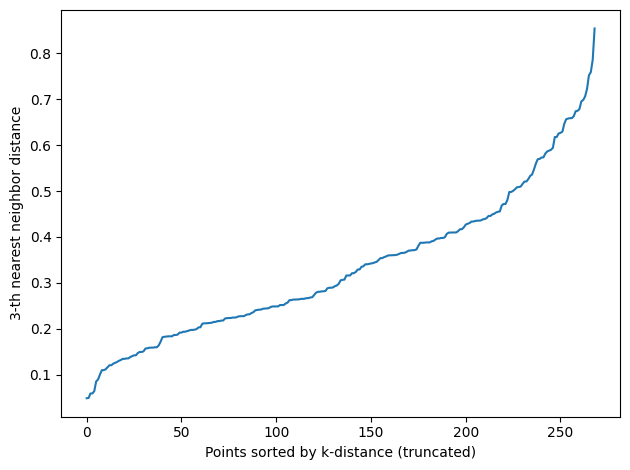

Approximate elbow at distance ≈ 0.456


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/document_topics_clustered_english1.csv')
X = df[['map_vector_0', 'map_vector_1']].values

# Compute k-distance for min_samples=3
min_samples = 3
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, _ = nbrs.kneighbors(X)
k_distances = distances[:, min_samples-1]
k_distances_sorted = np.sort(k_distances)

# Truncate to distances up to 1
kd_trunc = k_distances_sorted[k_distances_sorted <= 1]
N = len(kd_trunc)
x = np.arange(N)
y = kd_trunc

# Elbow detection via maximum distance to line
x1, y1 = 0, y[0]
x2, y2 = N - 1, y[-1]
a = y2 - y1
b = x1 - x2
c = x2*y1 - x1*y2
distances_to_line = np.abs(a*x + b*y + c) / np.sqrt(a*a + b*b)
elbow_index = np.argmax(distances_to_line)
elbow_value = y[elbow_index]

# Plot truncated k-distance curve
plt.figure()
plt.plot(kd_trunc)
plt.xlabel('Points sorted by k-distance (truncated)')
plt.ylabel(f'{min_samples}-th nearest neighbor distance')
plt.tight_layout()
plt.show()

print(f'Approximate elbow at distance ≈ {elbow_value:.3f}')

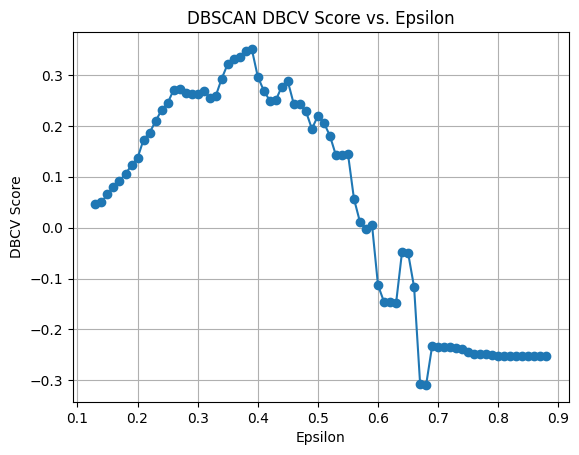

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.cluster import DBSCAN
from hdbscan.validity import validity_index

def load_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def filter_data(df: pd.DataFrame, column: str, threshold: float) -> pd.DataFrame:
    return df[df[column] <= threshold]

def compute_dbcv_scores(
    X: np.ndarray,
    eps_values: np.ndarray,
    min_samples: int = 4
) -> pd.DataFrame:
    scores = []
    for eps in eps_values:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
        core_clusters = set(labels) - {-1}
        if len(core_clusters) > 1:
            try:
                score = validity_index(X, labels)
            except Exception:
                score = np.nan
        else:
            score = np.nan
        scores.append(score)
    return pd.DataFrame({'eps': eps_values, 'dbcv_score': scores})

def rank_eps_scores(df_scores: pd.DataFrame) -> pd.DataFrame:
    df_clean = df_scores.dropna(subset=['dbcv_score'])
    return df_clean.sort_values(by='dbcv_score', ascending=False).reset_index(drop=True)

def plot_dbcv_vs_eps(df_scores: pd.DataFrame) -> None:
    plt.figure()
    plt.plot(df_scores['eps'], df_scores['dbcv_score'], marker='o', linestyle='-')
    plt.xlabel('Epsilon')
    plt.ylabel('DBCV Score')
    plt.title('DBSCAN DBCV Score vs. Epsilon')
    plt.grid(True)
    plt.show()

df = load_data('/content/document_topics_clustered_english1.csv')
df_filtered = filter_data(df, 'map_vector_0', 15)
X = df_filtered[['map_vector_0', 'map_vector_1']].values
eps_values = np.arange(0.1, 10.01, 0.01)
df_scores = compute_dbcv_scores(X, eps_values)
plot_dbcv_vs_eps(df_scores)
df_ranked = rank_eps_scores(df_scores)
# print("\nEpsilon values ranked by DBCV score (descending), NaNs excluded:")
# print(df_ranked.to_string(index=False))


## Step 2

In [ ]:
import pandas as pd
# Make sure pacmap is installed. If not, uncomment the next line
# !pip install pacmap # <- Run this in a separate cell if needed

# Import PaCMAP after potential installation
try:
    import pacmap
except ImportError:
    print("PaCMAP library not found. Please install it using: pip install pacmap")
    # Handle the error, e.g., exit or skip the PaCMAP part
    # For this example, we'll raise the error to stop execution
    raise ImportError("PaCMAP is required but not installed.")

def reduce(
    vectors: list[list[float]], # Or np.ndarray
    clusterisable_dimensions: int = 80,
    map_dimensions: int = 2,
) -> tuple[list[list[float]], list[list[float]]]:
    """Reduce the dimensionality of the given vectors using PaCMAP."""
    # PaCMAP configuration
    config = dict(
        n_neighbors=None,  # Let PaCMAP choose based on data size
        apply_pca=False,   # Set to True if initial PCA is desired
        save_tree=True,
        verbose=False,      # Set to False to reduce output messages
    )

    print(f"Reducing to {clusterisable_dimensions} dimensions for clustering...")
    clusterisabilitisation_model = pacmap.PaCMAP(n_components=clusterisable_dimensions, **config)
    # Using init='pca' can often improve stability and results
    clusterisable_vectors = clusterisabilitisation_model.fit_transform(vectors, init="pca")

    print(f"\nReducing to {map_dimensions} dimensions for mapping...")
    mapping_model = pacmap.PaCMAP(n_components=map_dimensions, **config)
    map_vectors = mapping_model.fit_transform(vectors, init="pca")

    # Return as NumPy arrays for easier handling later
    return clusterisable_vectors, map_vectors

def save_reduced_vectors(
    clusterisable_vectors: list[list[float]], # Or np.ndarray
    map_vectors: list[list[float]],           # Or np.ndarray
    metadata_df: pd.DataFrame,                # Original metadata DataFrame
    clusterisable_filename: str,
    map_filename_filenames_only: str,         # New filename for map + filenames
    map_filename_all_metadata: str            # New filename for map + all metadata
):
    """Save the reduced vectors, creating two versions of the map vectors file."""

    # Save clusterisable vectors (only numeric data)
    print(f"\nSaving clusterisable vectors to {clusterisable_filename}...")
    pd.DataFrame(clusterisable_vectors).to_csv(clusterisable_filename, index=False)

    # Prepare map vectors DataFrame
    map_df = pd.DataFrame(map_vectors, columns=['map_dim_1', 'map_dim_2'])

    # --- Save Map Vectors + Filenames Only ---
    print(f"Saving map vectors with filenames only to {map_filename_filenames_only}...")
    # Select only the filename column, ensure index alignment
    metadata_filenames = metadata_df[['filtered_filenames']].reset_index(drop=True)
    combined_map_filenames_df = pd.concat([metadata_filenames, map_df], axis=1)
    combined_map_filenames_df.to_csv(map_filename_filenames_only, index=False)

    # --- Save Map Vectors + All Metadata ---
    print(f"Saving map vectors with all metadata to {map_filename_all_metadata}...")
    # Use all relevant metadata columns, ensure index alignment
    metadata_all = metadata_df[['filtered_filenames', 'doc_texts_toprocess']].reset_index(drop=True)
    combined_map_all_df = pd.concat([metadata_all, map_df.copy()], axis=1) # Use map_df.copy() just to be safe if needed later, though not strictly necessary here
    combined_map_all_df.to_csv(map_filename_all_metadata, index=False)

    print("Saving complete.")

# --- Main Script ---
# 1. Load the data
input_filename = 'og_vecs_w_commission.csv'
print(f"Loading data from {input_filename}...")
df = pd.read_csv(input_filename)

# 2. Identify and select vector columns and metadata columns
# Assuming vectors are '0' to '1023' and metadata are the last two columns
vector_columns = [str(i) for i in range(1024)] # Adjust range if needed
metadata_columns = ['filtered_filenames', 'doc_texts_toprocess']

# Check if these columns exist
missing_vec_cols = [col for col in vector_columns if col not in df.columns]
if missing_vec_cols:
    print(f"Warning: The following expected vector columns were not found: {missing_vec_cols}")
    vector_columns = [col for col in vector_columns if col in df.columns]
    if not vector_columns:
        raise ValueError("No valid vector columns found in the CSV file.")

missing_meta_cols = [col for col in metadata_columns if col not in df.columns]
if missing_meta_cols:
     raise ValueError(f"Metadata columns not found: {missing_meta_cols}")

print(f"Extracting vectors from {len(vector_columns)} columns...")
vectors_np = df[vector_columns].values

print(f"Extracting metadata from columns: {metadata_columns}")
metadata_df = df[metadata_columns]

# Check for non-numeric data or NaNs in vectors
if pd.api.types.is_numeric_dtype(vectors_np.dtype):
     if pd.isna(vectors_np).any().any(): # Check if *any* value is NaN
          print("Warning: Vector data contains NaN values. PaCMAP might fail or produce unexpected results.")
          # Consider imputation strategies here if needed
else:
     print("Warning: Vector data is not purely numeric. Attempting conversion...")
     try:
        vectors_np = vectors_np.astype(float)
        if pd.isna(vectors_np).any().any():
             print("Warning: Vector data contains NaN values after conversion. PaCMAP might fail or produce unexpected results.")
             # Consider imputation here as well
     except ValueError as e:
        raise TypeError(f"Could not convert vector data to numeric. Error: {e}")


print(f"Shape of vector data: {vectors_np.shape}")
print(f"Shape of metadata: {metadata_df.shape}")

# 3. Define output filenames
clusterisable_output_filename = 'clusterisable_vectors_80d.csv'
map_output_filename_filenames = 'map_vectors_2d_with_filenames.csv'
map_output_filename_all_meta = 'map_vectors_2d_with_all_metadata.csv'

# 4. Run the dimensionality reduction
clusterisable_vecs_np, map_vecs_np = reduce(vectors=vectors_np) # Returns numpy arrays

# 5. Save the results
save_reduced_vectors(
    clusterisable_vecs_np,
    map_vecs_np,
    metadata_df,
    clusterisable_output_filename,
    map_output_filename_filenames,  # Pass the new filename
    map_output_filename_all_meta    # Pass the second new filename
)

print("\nProcess finished.")
print(f"Clusterisable vectors saved to '{clusterisable_output_filename}' ({clusterisable_vecs_np.shape[1]} dimensions).")
print(f"Map vectors (2D) with filenames saved to '{map_output_filename_filenames}'.")
print(f"Map vectors (2D) with all metadata saved to '{map_output_filename_all_meta}'.")

# Display first 5 rows of the new map vectors files to verify
print(f"\nFirst 5 rows of {map_output_filename_filenames}:")
print(pd.read_csv(map_output_filename_filenames).head().to_markdown(index=False, numalign="left", stralign="left"))

print(f"\nFirst 5 rows of {map_output_filename_all_meta}:")
print(pd.read_csv(map_output_filename_all_meta).head().to_markdown(index=False, numalign="left", stralign="left"))

Loading data from og_vecs_w_commission.csv...


Extracting vectors from 1024 columns...
Extracting metadata from columns: ['filtered_filenames', 'doc_texts_toprocess']
Shape of vector data: (318, 1024)
Shape of metadata: (318, 2)
Reducing to 80 dimensions for clustering...


Streaming output truncated to the last 5000 lines.
|                                                               | the total number of recipients of the service reached and, where applicable,                                                                                                                       |             |             |
|                                                               | aggregate numbers for the group or groups of recipients to whom the                                                                                                                                |             |             |
|                                                               | advertisement was targeted specifically.                                                                                                                                                           |             |             |
|                                                               | Article 31